In [1]:
1*2

2

In [1]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% | 73% |
|  1 |  0% | 24% |
|  2 |  0% | 24% |
|  3 |  0% | 24% |
|  4 |  0% | 24% |
|  5 |  0% | 24% |
|  6 |  0% | 24% |
|  7 |  0% | 24% |


In [3]:
import dask.dataframe as dd
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import torch
import gpytorch

import pyarrow as pa
import pyarrow.parquet as pq

from scipy.stats import pearsonr
from scipy.special import binom as binom
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

import Di

In [4]:
df = pd.read_csv("96ghpptzvf-4/SData2/CoCl2_geno.txt", sep='\t', nrows=5, engine='python')

ids = list(df.columns[3:])

In [5]:
geno_t = torch.load('matsui_geno_t.pt')
geno_t = torch.transpose(geno_t, 0, 1)

geno_pd = pd.DataFrame(geno_t.cpu().numpy())

geno_pd['id'] = ids

geno_pd = geno_pd.set_index('id')

In [6]:
pheno_files = os.listdir('96ghpptzvf-4/SData6')

pheno_files.remove('.ipynb_checkpoints')

pheno_list = [file.split('_')[0] for file in pheno_files]

In [7]:
phenotype = pheno_list[0]
print(phenotype)

CuSO4


In [8]:
pheno = pd.read_csv("96ghpptzvf-4/SData6/" + phenotype + "_pheno.txt", sep='\t', engine="python")

In [9]:
pheno.head()

,pheno,MATa,MATalpha,geno,qnorm,MATa_mid,MATalpha_mid,midparent
0,-0.130446,y39_A012,BYa_1C_A10,BYa_1C_A10.y39_A012,-0.805458,-0.952233,-0.837107,-0.894670
1,-0.293409,y39_A02,BYa_1C_A10,BYa_1C_A10.y39_A02,-1.907256,-0.190852,-0.837107,-0.513980
2,-0.097135,y39_A03,BYa_1C_A10,BYa_1C_A10.y39_A03,-0.544212,-0.705837,-0.837107,-0.771472
3,-0.241682,y39_A04,BYa_1C_A10,BYa_1C_A10.y39_A04,-1.666606,-0.632964,-0.837107,-0.735035
4,-0.168537,y39_A05,BYa_1C_A10,BYa_1C_A10.y39_A05,-1.111989,-0.051998,-0.837107,-0.444552


In [10]:
pheno = pheno.set_index('geno')

In [11]:
ids_0 = sorted(list(set(pheno.index).intersection(set(ids))))

In [12]:
pheno = pheno.loc[ids_0]

In [13]:
geno_pd = geno_pd.loc[ids_0]

In [14]:
geno_t = torch.tensor(geno_pd.to_numpy()).cuda()

In [15]:
N, L = geno_t.shape

In [26]:
sub = np.random.choice(range(N), 15000)

In [27]:
import Di
Di.set_params(geno_t[sub])

In [28]:
p = .8

In [29]:
from torch.utils.data import random_split
train, test = random_split(range(Di.N), lengths=[round(Di.N*p), Di.N-round(Di.N*p)])

In [30]:
y = np.array(pheno.pheno[sub])
y = torch.tensor(y)

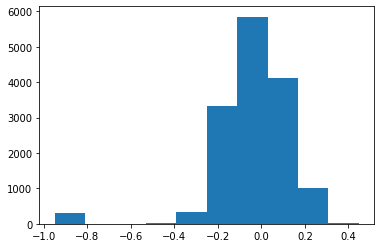

In [31]:
plt.hist(np.array(y))
plt.show()

In [32]:
idc = torch.arange(Di.N)

In [33]:
train_x = idc[train]
train_y = torch.tensor(y[train])
test_x = idc[test]
test_y = torch.tensor(y[test])

/scratch/local/25041937/ipykernel_144148/2969457204.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = torch.tensor(y[train])
/scratch/local/25041937/ipykernel_144148/2969457204.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_y = torch.tensor(y[test])


In [34]:
train_x = train_x.cuda()
train_y = train_y.cuda().float()

In [35]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = Di.LinGPModel(train_x, train_y, likelihood)

model = model.cuda().double()
likelihood = likelihood.cuda()

model.train()
output = model(train_x)

model.train()
likelihood.train()
losses = Di.train_model(model, likelihood, train_x, train_y, training_iter=10, lr=.2)

0


tensor([-0.0082,  0.0190, -0.2121,  ...,  0.0367, -0.0485, -0.2092],
       device='cuda:0', dtype=torch.float64, grad_fn=<ViewBackward>)

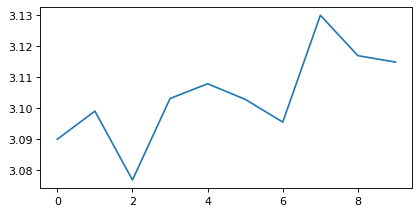

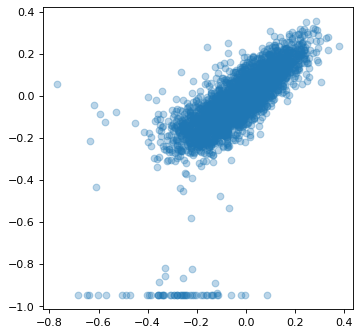

r2 = 0.512667
R2 = 0.511175
mse = 0.015343


In [40]:
figure(figsize=(6, 3), dpi=80)
plt.plot(losses)
plt.show()

test_x = test_x.cuda()

model.eval()
f_preds = model(test_x)

f_mean = f_preds.mean.cpu()

figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean.detach().numpy(), y[test], 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean.detach().numpy(), y[test])[0]**2)
print('R2 = %f'%r2(y[test], f_mean.detach().numpy()))
print('mse = %f'%mse(f_mean.detach().numpy(), y[test]))

In [45]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = Di.DiGPModel(train_x, train_y, likelihood)

model = model.cuda().double()
likelihood = likelihood.cuda()

model.covar_module.raw_lda = torch.nn.Parameter(torch.tensor(-8.))
model.covar_module.raw_eta = torch.nn.Parameter(torch.tensor(-12.))
model.covar_module.raw_ld1 = torch.nn.Parameter(torch.tensor(-8.))
model.covar_module.raw_et1 = torch.nn.Parameter(torch.tensor(-12.))

model.train()
output = model(train_x)

model.train()
likelihood.train()
losses = Di.train_model(model, likelihood, train_x, train_y, training_iter=1000, lr=.1)

0


/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /pytorch/aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


RuntimeError: CUDA out of memory. Tried to allocate 1.07 GiB (GPU 0; 79.35 GiB total capacity; 75.54 GiB already allocated; 3.19 MiB free; 77.49 GiB reserved in total by PyTorch)

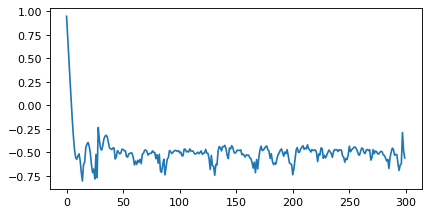

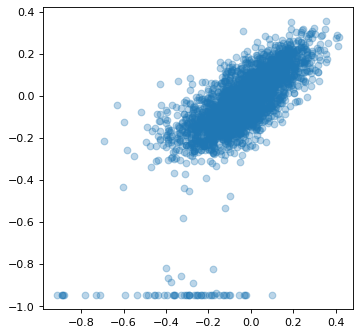

r2 = 0.471248
R2 = 0.436223
mse = 0.017695


In [42]:
figure(figsize=(6, 3), dpi=80)
plt.plot(losses)
plt.show()

test_x = test_x.cuda()

model.eval()
f_preds = model(test_x)
f_mean = f_preds.mean.cpu()

figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean.detach().numpy(), y[test], 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean.detach().numpy(), y[test])[0]**2)
print('R2 = %f'%r2(y[test], f_mean.detach().numpy()))
print('mse = %f'%mse(f_mean.detach().numpy(), y[test]))

In [57]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = Di.RBFGPModel(train_x, train_y, likelihood)

model = model.cuda().double()
likelihood = likelihood.cuda()

model.train()
output = model(train_x)

model.train()
likelihood.train()
losses = Di.train_model(model, likelihood, train_x, train_y, training_iter=300, lr=.2)

0


/home/juannanzhou/.local/lib/python3.8/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /pytorch/aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


20
40
60
80
100
120
140
160
180
200
220
240
260
280


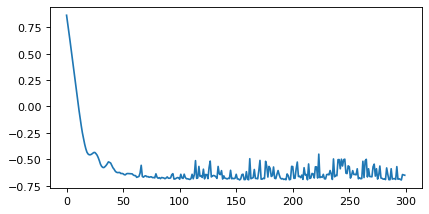

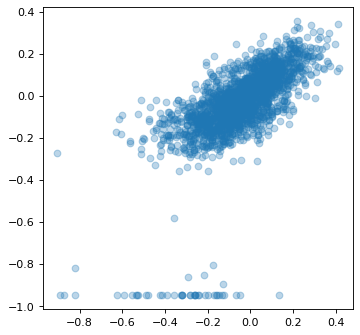

r2 = 0.421896
R2 = 0.341257
mse = 0.021647


In [58]:
figure(figsize=(6, 3), dpi=80)
plt.plot(losses)
plt.show()

test_x = test_x.cuda()

model.eval()
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean.cpu()

figure(figsize=(5, 5), dpi=80)
plt.plot(f_mean.detach().numpy(), y[test], 'o', alpha=.3)
plt.show()
print('r2 = %f'%pearsonr(f_mean.detach().numpy(), y[test])[0]**2)
print('R2 = %f'%r2(y[test], f_mean.detach().numpy()))
print('mse = %f'%mse(f_mean.detach().numpy(), y[test]))